In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam,SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121
import pandas as pd
import numpy as pd

from keras.preprocessing import image 
from keras.preprocessing.image import ImageDataGenerator
img_size=336
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.1,
    horizontal_flip = True,
    vertical_flip = True,
    validation_split = 0.0,
    width_shift_range=0.2,
    height_shift_range=0.2)

valid_datagen = ImageDataGenerator(
    rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/cassava_aug_data/train',  #training data path
        target_size=(img_size, img_size),
        batch_size=32,
        class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(
        '/content/drive/MyDrive/cassava_aug_data/val', #validation data path
        target_size=(img_size, img_size),
        batch_size=32,
        class_mode='categorical',
        shuffle = False)

SIZE=336
channel=3


def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE,channel))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(5,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    #lr=0.002
    optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    #optimizer = SGD(lr=1e-5,momentum=0.9)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

filepath = '/content/drive/MyDrive/cassava_dense121.h5'   #path where the model should be saved
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=True)

model = build_densenet()

Found 6000 images belonging to 5 classes.
Found 1500 images belonging to 5 classes.
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 336, 336, 3)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 336, 336, 3)       84        
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________

In [13]:
history = model.fit(train_generator,
                   validation_steps = valid_generator.n // valid_generator.batch_size,
                   validation_data = valid_generator,
                   steps_per_epoch = train_generator.n // train_generator.batch_size ,
                   epochs = 50,
                   callbacks = [annealer,checkpoint])


Epoch 1/50
187/187 [==============================] - 2128s 11s/step - loss: 2.5705 - accuracy: 0.2315 - val_loss: 1.4754 - val_accuracy: 0.3838

Epoch 00001: val_loss improved from inf to 1.47537, saving model to /content/drive/MyDrive/cassava_dense121.h5
Epoch 2/50
187/187 [==============================] - 234s 1s/step - loss: 1.9964 - accuracy: 0.3519 - val_loss: 1.1577 - val_accuracy: 0.5428

Epoch 00002: val_loss improved from 1.47537 to 1.15768, saving model to /content/drive/MyDrive/cassava_dense121.h5
Epoch 3/50
187/187 [==============================] - 233s 1s/step - loss: 1.6672 - accuracy: 0.4518 - val_loss: 0.9462 - val_accuracy: 0.6562

Epoch 00003: val_loss improved from 1.15768 to 0.94615, saving model to /content/drive/MyDrive/cassava_dense121.h5
Epoch 4/50
187/187 [==============================] - 232s 1s/step - loss: 1.4518 - accuracy: 0.5127 - val_loss: 0.8303 - val_accuracy: 0.6977

Epoch 00004: val_loss improved from 0.94615 to 0.83026, saving model to /content/

In [14]:

model.save(filepath)

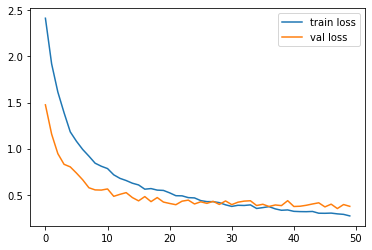

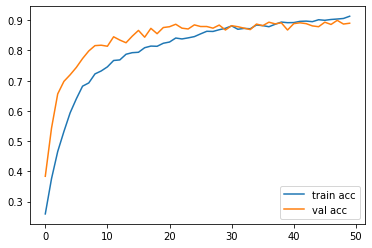

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('/content/drive/MyDrive/dense_loss_curve')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('/content/drive/MyDrive/dense_acc_curve')


In [16]:
from tensorflow import keras
model = keras.models.load_model(filepath)

In [17]:
from keras.preprocessing import image 
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
import numpy as np
img_size=336
test_datagen = ImageDataGenerator(
   
    rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/cassava_aug_data/test',
        target_size=(img_size, img_size),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

Found 200 images belonging to 5 classes.


In [18]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    """

    This function prints and plots the confusion matrix.

    Normalization can be applied by setting `normalize=True`.

    """

    plt.figure(figsize=(10,10))



    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)

    plt.colorbar()



    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)



    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        cm = np.around(cm, decimals=2)

        cm[np.isnan(cm)] = 0.0

        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],

                 horizontalalignment="center",

                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()

    plt.ylabel('True label')

    plt.xlabel('Predicted label')

In [19]:
target_names = []

for key in train_generator.class_indices:

    target_names.append(key)

In [20]:
predict = model.predict_generator(valid_generator)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [21]:
predict1=model.predict_generator(test_generator)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[248  35   5   5   7]
 [  3 274   6  13   4]
 [  2  18 257  13  10]
 [  0  15   8 275   2]
 [  4   9   6   4 277]]
Confusion matrix, without normalization


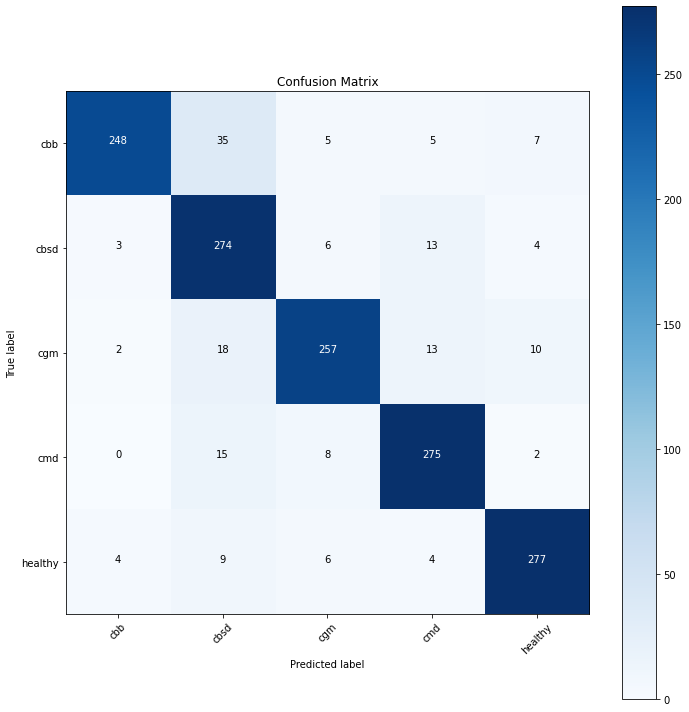

In [22]:
y_pred = np.argmax(predict, axis=1)

print('Confusion Matrix')

cm = confusion_matrix(valid_generator.classes, y_pred)
print(cm)

import itertools
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')




Confusion Matrix
[[26 11  2  0  1]
 [ 0 40  0  0  0]
 [ 0  0 40  0  0]
 [ 0  1  0 39  0]
 [ 3  0  0  1 36]]
Confusion matrix, without normalization


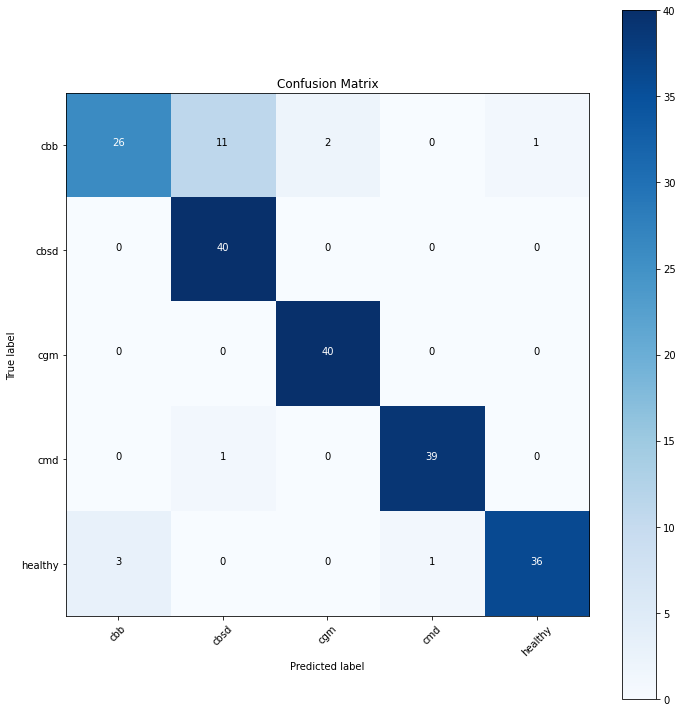

In [23]:
y_pred1 = np.argmax(predict1, axis=1)

print('Confusion Matrix')

cm = confusion_matrix(test_generator.classes, y_pred1)
print(cm)

import itertools
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')




In [24]:
print(classification_report(test_generator.classes, y_pred1, target_names=target_names))

              precision    recall  f1-score   support

         cbb       0.90      0.65      0.75        40
        cbsd       0.77      1.00      0.87        40
         cgm       0.95      1.00      0.98        40
         cmd       0.97      0.97      0.97        40
     healthy       0.97      0.90      0.94        40

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.90       200
weighted avg       0.91      0.91      0.90       200



In [25]:
pip install keract

In [26]:

x_batch, y_batch = next(train_generator)
model = keras.models.load_model('/content/drive/MyDrive/cassava_dense121.h5')


In [27]:

#visualizing mobile net (dense net not working for visualization)
from keract import get_activations, display_activations
keract_inputs = x_batch[:1]
keract_targets = y_batch[:1]
activations = get_activations(model, keract_inputs)
display_activations(activations, cmap="gray", save=False)

Run it without eager mode. Paste those commands at the beginning of your script:
> import tensorflow as tf
> tf.compat.v1.disable_eager_execution()


ValueError: ignored